# CNC Tool Wear Prediction Using Machine Learning

This notebook implements a predictive maintenance workflow for CNC tool wear
estimation using sensor data. The objective is to predict tool flank wear (VB_mm)
over time and trigger warnings before failure using a sliding-window based
machine learning approach.

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import kurtosis
from scipy.fft import fft
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

### Exploring Data points

In [2]:
df=pd.read_csv("Tool_wear_dataset.csv")
print(df.head())

   CF_Feature_1  CF_Feature_2  CF_Feature_3  CF_Feature_4  CF_Feature_5  \
0     37.454012     95.071431     73.199394     59.865848     15.601864   
1     15.599452      5.808361     86.617615     60.111501     70.807258   
2      2.058449     96.990985     83.244264     21.233911     18.182497   
3     18.340451     30.424224     52.475643     43.194502     29.122914   
4     61.185289     13.949386     29.214465     36.636184     45.606998   

   Vib_Feature_1  Vib_Feature_2  Vib_Feature_3  Vib_Feature_4  Vib_Feature_5  \
0       3.736408       3.329121       1.761539       6.072667       4.766242   
1       8.657010       0.321096       6.438679       7.629489       7.594866   
2       8.860740       7.290337       9.278101       3.326566       5.032094   
3       0.140797       0.069576       2.401266       1.008072       2.602114   
4       1.770433       0.285200       9.093041       0.082231       7.360821   

   AE_Feature_1  AE_Feature_2  AE_Feature_3  AE_Feature_4  AE_Featur

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CF_Feature_1   2000 non-null   float64
 1   CF_Feature_2   2000 non-null   float64
 2   CF_Feature_3   2000 non-null   float64
 3   CF_Feature_4   2000 non-null   float64
 4   CF_Feature_5   2000 non-null   float64
 5   Vib_Feature_1  2000 non-null   float64
 6   Vib_Feature_2  2000 non-null   float64
 7   Vib_Feature_3  2000 non-null   float64
 8   Vib_Feature_4  2000 non-null   float64
 9   Vib_Feature_5  2000 non-null   float64
 10  AE_Feature_1   2000 non-null   float64
 11  AE_Feature_2   2000 non-null   float64
 12  AE_Feature_3   2000 non-null   float64
 13  AE_Feature_4   2000 non-null   float64
 14  AE_Feature_5   2000 non-null   float64
 15  VB_mm          2000 non-null   float64
 16  Wear_Class     2000 non-null   object 
dtypes: float64(16), object(1)
memory usage: 265.8+ KB
No

In [4]:
print(df.describe())

       CF_Feature_1  CF_Feature_2  CF_Feature_3  CF_Feature_4  CF_Feature_5  \
count   2000.000000   2000.000000   2000.000000   2000.000000   2000.000000   
mean      49.072475     49.653094     49.165325     50.063471     49.125413   
std       28.822497     28.957328     28.970279     28.409174     28.667882   
min        0.022704      0.003072      0.001163      0.040154      0.013469   
25%       24.701428     23.829483     24.119092     26.442521     24.183035   
50%       48.168881     50.083346     49.214754     49.656655     49.117576   
75%       74.250184     74.143315     74.162992     74.180415     73.172261   
max       99.890470     99.971767     99.950519     99.946068     99.955770   

       Vib_Feature_1  Vib_Feature_2  Vib_Feature_3  Vib_Feature_4  \
count    2000.000000    2000.000000    2000.000000    2000.000000   
mean        5.104362       4.912235       5.113349       5.076789   
std         2.885918       2.917495       2.926230       2.851267   
min         

In [5]:
df=df.reset_index(drop=True)
df["Time_step"]=df.index

In [6]:
#Checking for duplicate rows
print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [CF_Feature_1, CF_Feature_2, CF_Feature_3, CF_Feature_4, CF_Feature_5, Vib_Feature_1, Vib_Feature_2, Vib_Feature_3, Vib_Feature_4, Vib_Feature_5, AE_Feature_1, AE_Feature_2, AE_Feature_3, AE_Feature_4, AE_Feature_5, VB_mm, Wear_Class, Time_step]
Index: []


In [7]:
#Displaying unique values of the Classification target label
print(df["Wear_Class"].value_counts())

Wear_Class
Moderate    854
Healthy     580
Worn        566
Name: count, dtype: int64


In [8]:
#Encoding the categorical feature
Encoder=LabelEncoder()
df["Wear_Class"]=Encoder.fit_transform(df["Wear_Class"])
print(df["Wear_Class"].value_counts())

Wear_Class
1    854
0    580
2    566
Name: count, dtype: int64


## Visualisation

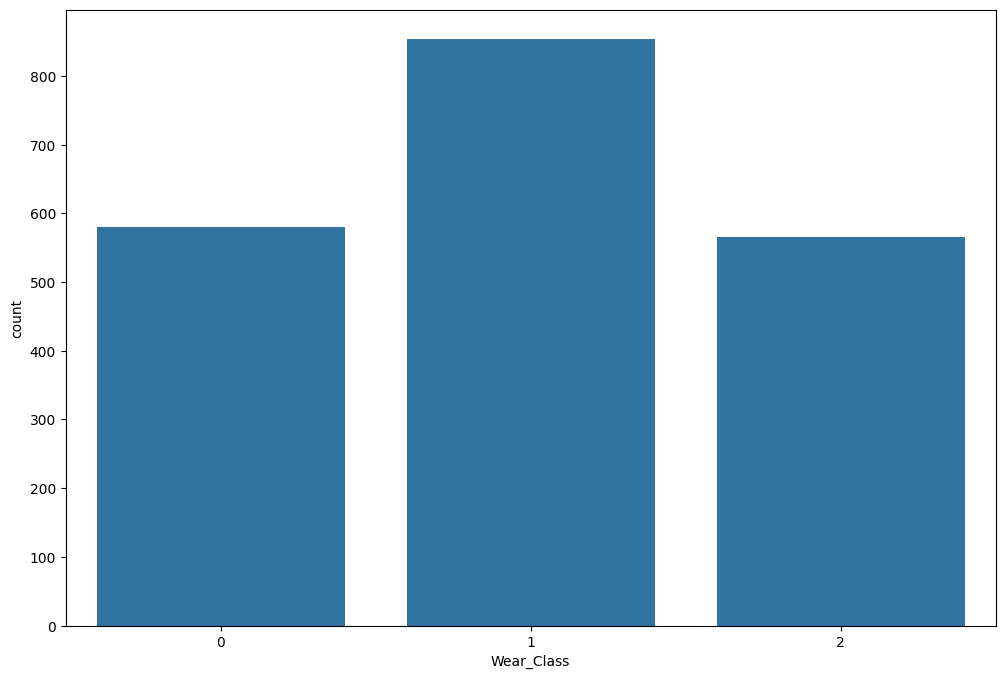

In [9]:
#countplot
plt.figure(figsize=(12,8))
sns.countplot(data=df,x="Wear_Class")
plt.show()

Checking if the dataset is time dependent

In [10]:
#Checking monotonic behaviour
transitions=df['Wear_Class'].diff().dropna()
print("Number of backward transitions: ",sum(transitions<0))
print("Number of forward transitions: ",sum(transitions>0))
print("Number of no-change transitions: ",sum(transitions==0))


Number of backward transitions:  57
Number of forward transitions:  59
Number of no-change transitions:  1883


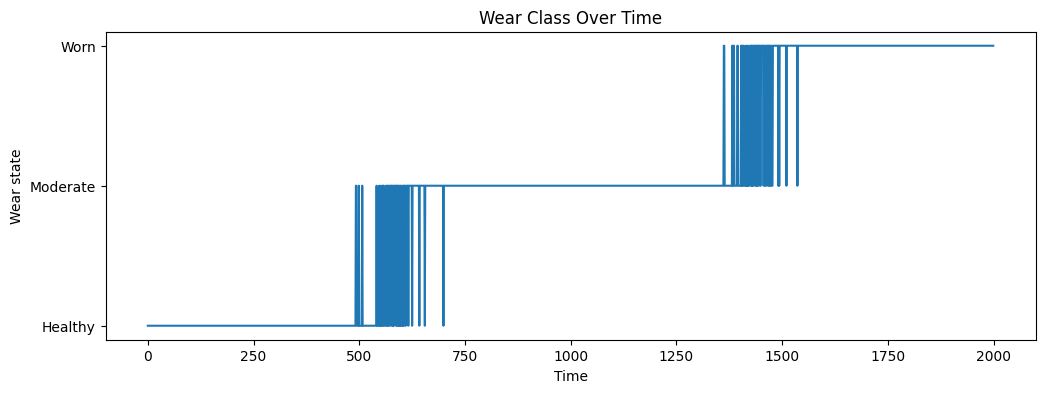

In [11]:
#line plot
plt.figure(figsize=(12,4))
plt.plot(df['Wear_Class'])
plt.title("Wear Class Over Time")
plt.yticks([0,1,2],["Healthy","Moderate","Worn"])
plt.xlabel("Time")
plt.ylabel("Wear state")
plt.show()

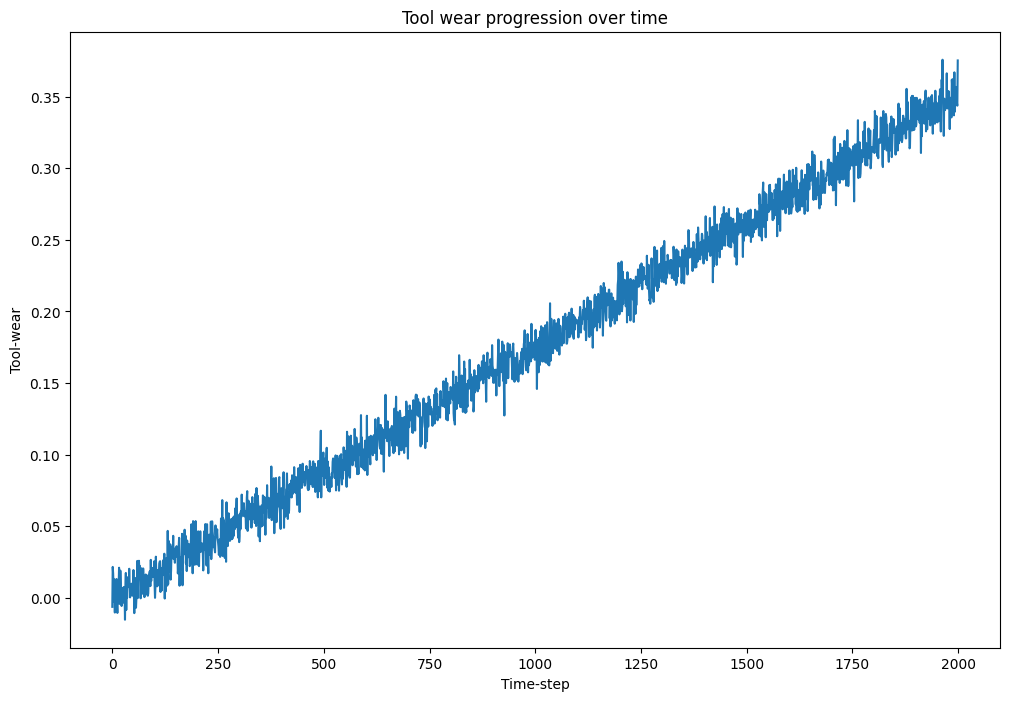

In [12]:
#line plot
plt.figure(figsize=(12,8))
plt.plot(df["Time_step"],df["VB_mm"])
plt.xlabel("Time-step")
plt.ylabel("Tool-wear")
plt.title("Tool wear progression over time")
plt.show()

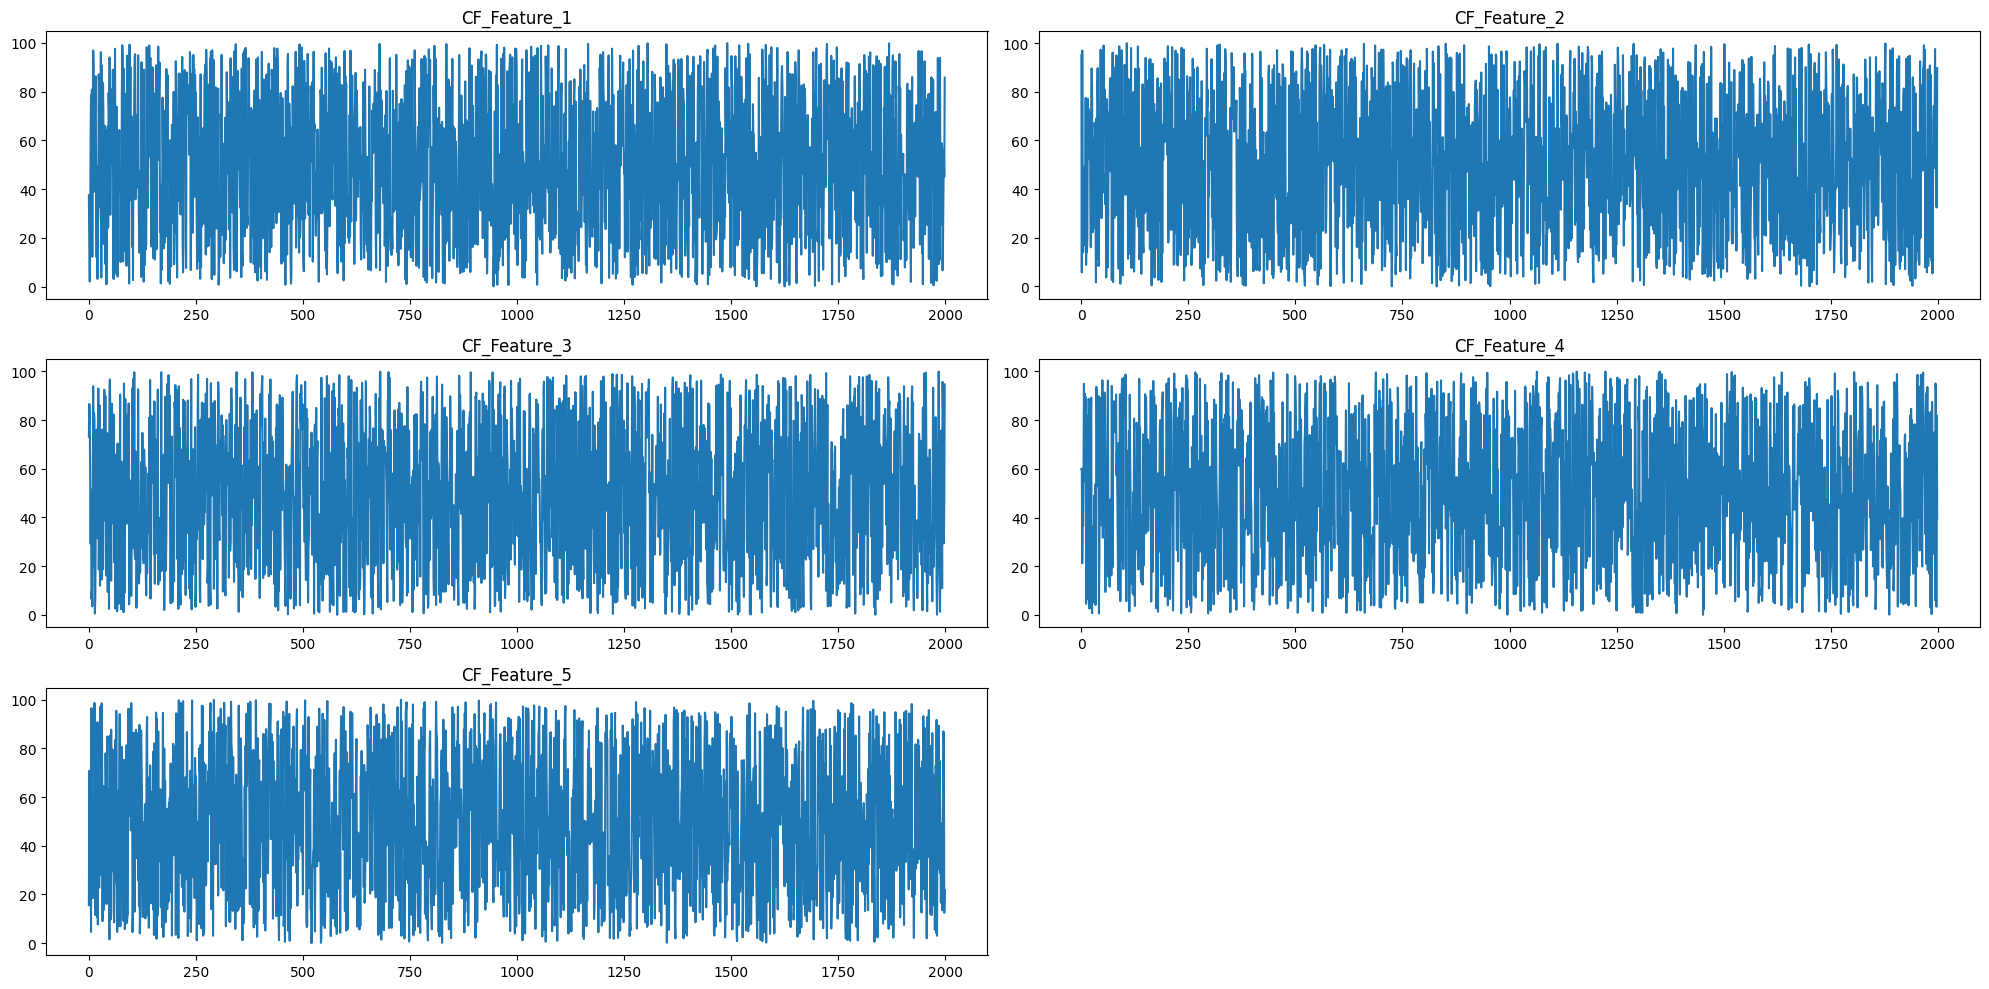

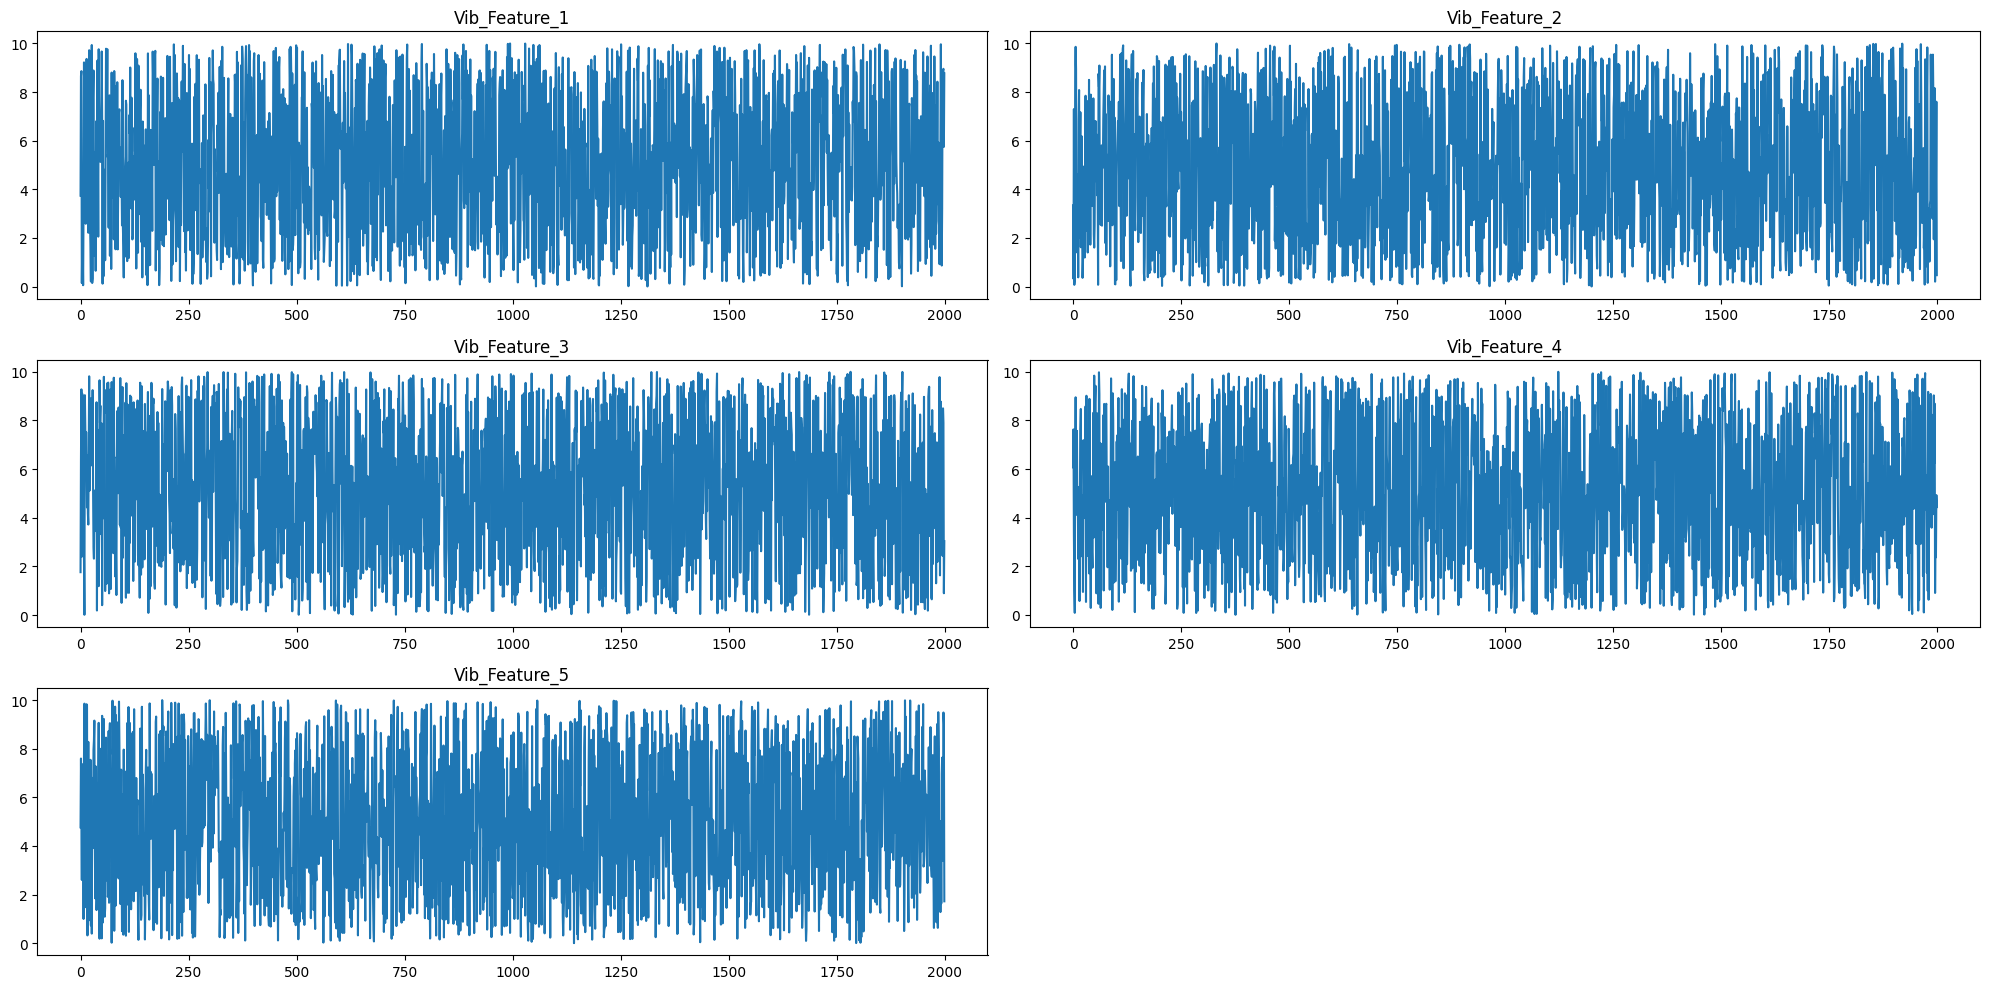

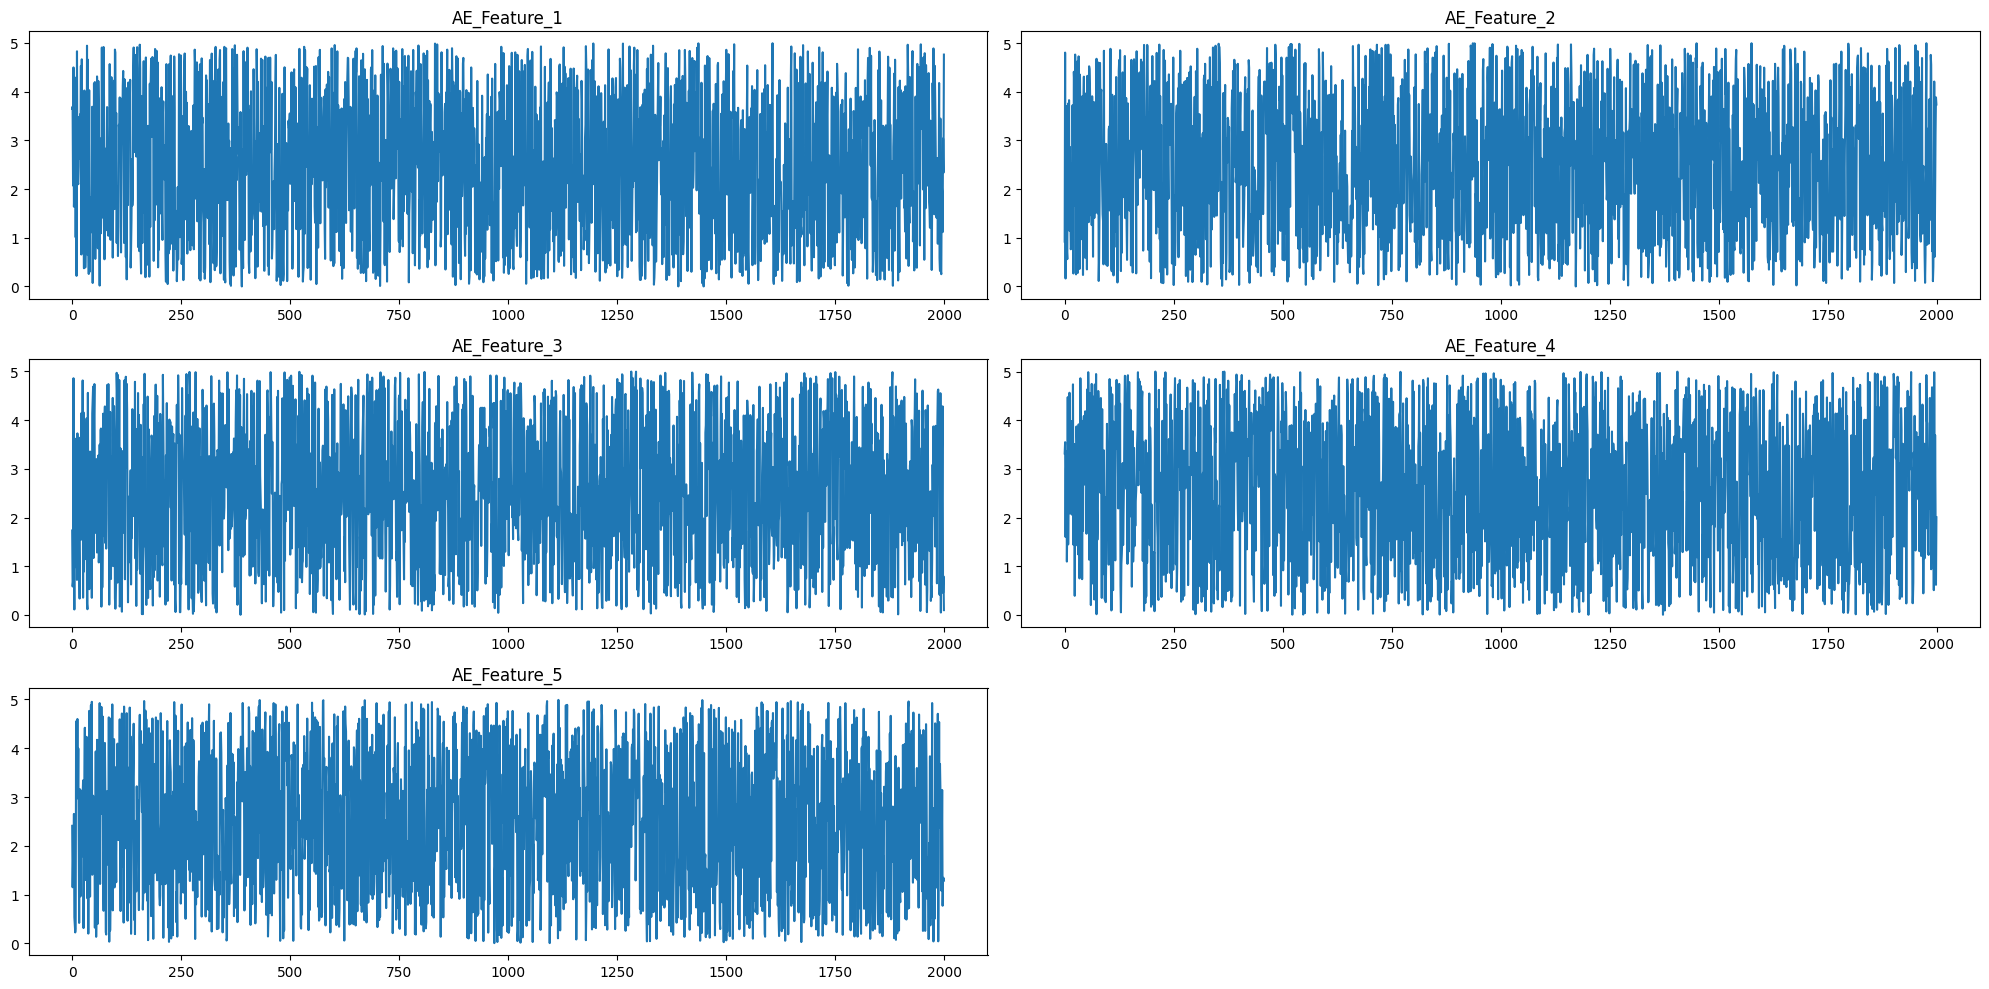

In [13]:
#line plot
sensor_columns=["CF_Feature_1","CF_Feature_2","CF_Feature_3","CF_Feature_4","CF_Feature_5","Vib_Feature_1","Vib_Feature_2","Vib_Feature_3","Vib_Feature_4","Vib_Feature_5","AE_Feature_1","AE_Feature_2","AE_Feature_3","AE_Feature_4","AE_Feature_5"]
for i in range(3):
    plt.figure(figsize=(20,10))
    for j in range(5):
        plt.subplot(3,2,j+1)
        plt.plot(df["Time_step"],df[sensor_columns[(i*5)+j]])
        plt.title(sensor_columns[(i*5)+j])
        
    plt.tight_layout()
    plt.show()

[]

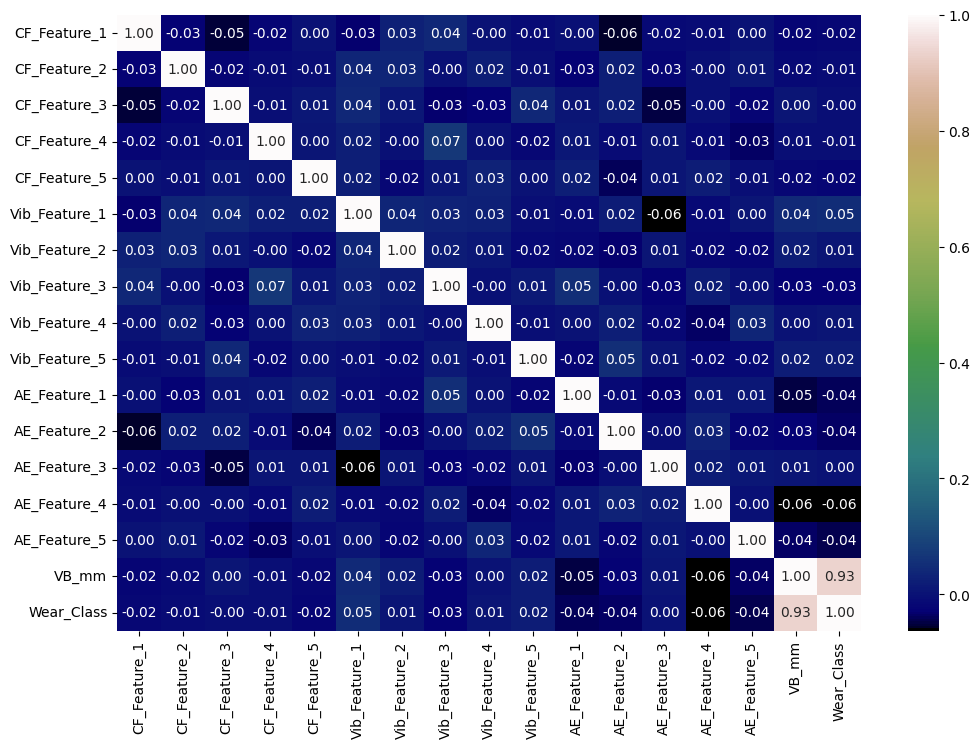

In [14]:
#correlation matrix
corr_mat=df.drop(columns="Time_step").corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_mat,fmt=".2f",annot=True,cmap="gist_earth")
plt.plot()

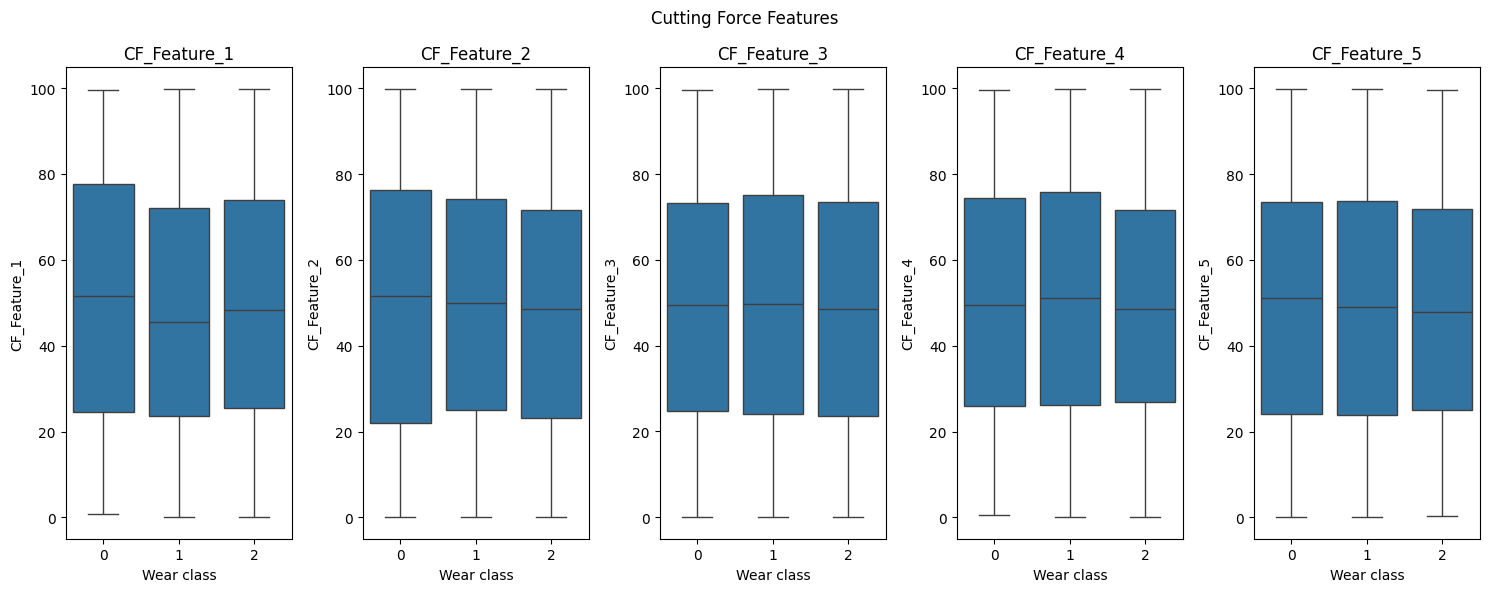

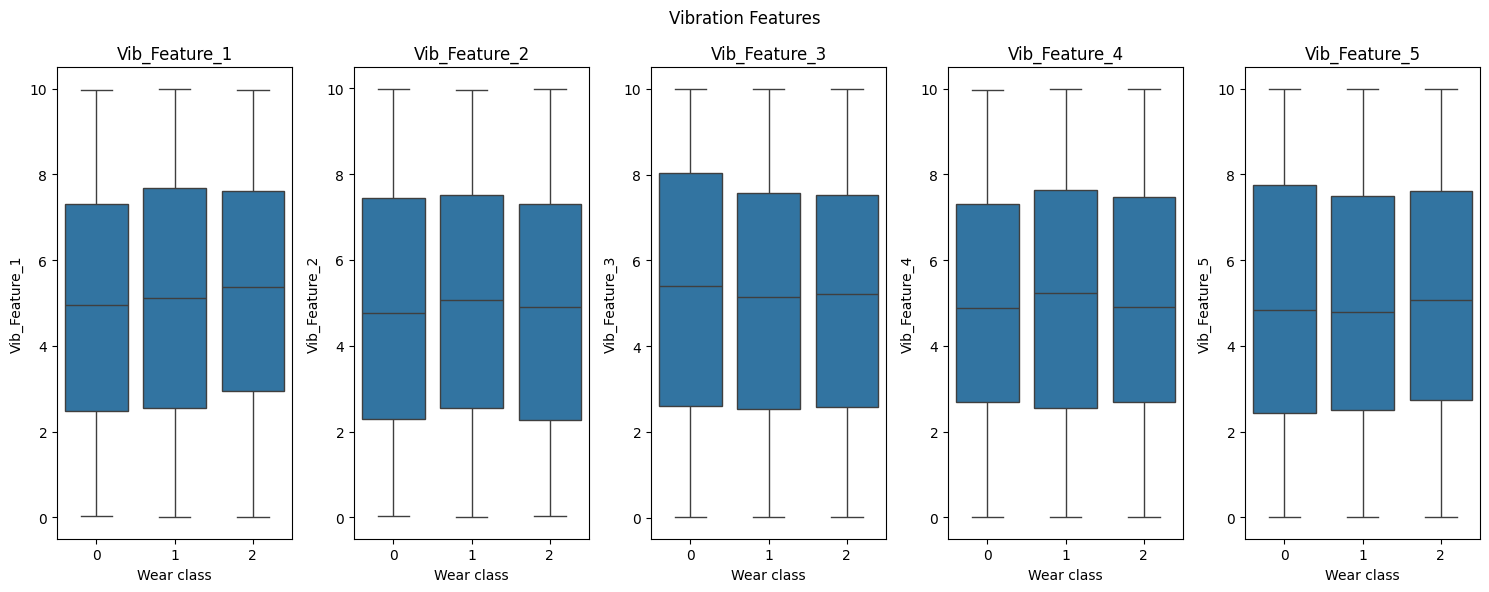

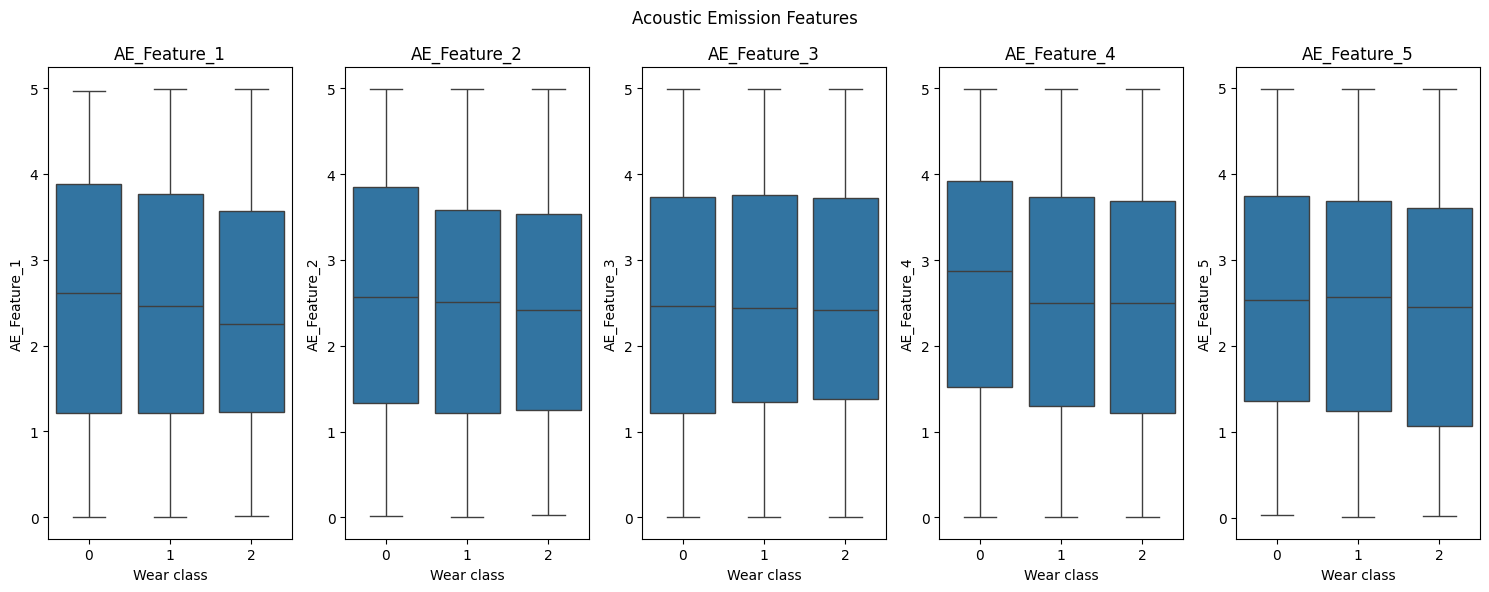

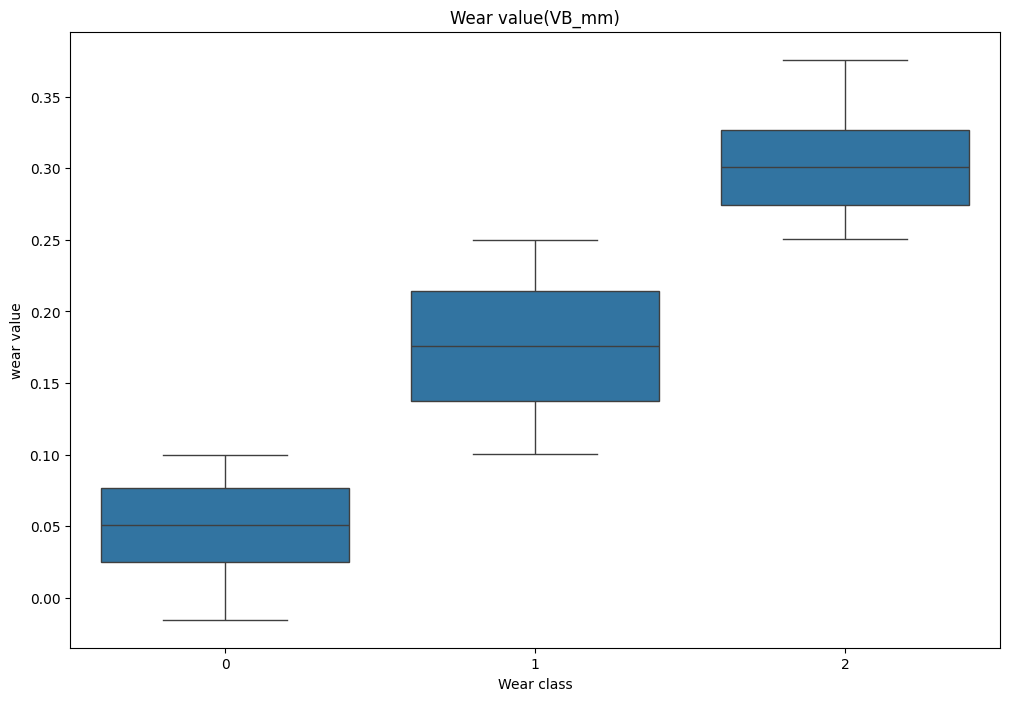

In [15]:
#box plot
cf_cols=["CF_Feature_1","CF_Feature_2","CF_Feature_3","CF_Feature_4","CF_Feature_5"]
vib_cols=["Vib_Feature_1","Vib_Feature_2","Vib_Feature_3","Vib_Feature_4","Vib_Feature_5"]
ae_cols=["AE_Feature_1","AE_Feature_2","AE_Feature_3","AE_Feature_4","AE_Feature_5"]

plt.figure(figsize=(15,6))
plt.suptitle("Cutting Force Features")
i=1
for col in cf_cols:
    plt.subplot(1,len(cf_cols),i)
    sns.boxplot(data=df,x="Wear_Class",y=col)
    plt.title(col)
    plt.xlabel("Wear class")
    plt.ylabel(col)
    plt.tight_layout()
    i+=1
plt.show()

plt.figure(figsize=(15,6))
plt.suptitle("Vibration Features")
i=1
for col in vib_cols:
    plt.subplot(1,len(vib_cols),i)
    sns.boxplot(data=df,x="Wear_Class",y=col)
    plt.title(col)
    plt.xlabel("Wear class")
    plt.ylabel(col)
    plt.tight_layout()
    i+=1
plt.show()

plt.figure(figsize=(15,6))
plt.suptitle("Acoustic Emission Features")
i=1
for col in ae_cols:
    plt.subplot(1,len(ae_cols),i)
    sns.boxplot(data=df,x="Wear_Class",y=col)
    plt.title(col)
    plt.xlabel("Wear class")
    plt.ylabel(col)
    plt.tight_layout()
    i+=1
plt.show()

plt.figure(figsize=(12,8))
plt.title("Wear value(VB_mm)")
sns.boxplot(data=df,x="Wear_Class",y="VB_mm")
plt.xlabel("Wear class")
plt.ylabel("wear value")
plt.show()

#### Non Overlapping Windows

In [16]:
#BASELINE:NON-OVERLAPPING WINDOWS
window_size=100
window_cnt=len(df)//window_size

df_updated=[]

for window_index in range(window_cnt):
    start=window_index*window_size
    end=start+window_size

    req_feat=df.iloc[start:end,:]

    window_df_wearclass=req_feat["Wear_Class"].mode()[0]

    window_df_vb_mm=req_feat["VB_mm"].mean()

    window_row={}
    window_row["Window_ID"]=window_index  
    window_row["Wear_Class"]=window_df_wearclass
    window_row["VB_mm"]=window_df_vb_mm

    for col in sensor_columns:
        window_row[col]=req_feat[col].values
    
    df_updated.append(window_row)

df_updated=pd.DataFrame(df_updated)

print(df_updated.head())


   Window_ID  Wear_Class     VB_mm  \
0          0           0  0.008475   
1          1           0  0.026057   
2          2           0  0.042224   
3          3           0  0.062092   
4          4           0  0.080370   

                                        CF_Feature_1  \
0  [37.454011884736246, 15.599452033620263, 2.058...   
1  [69.81617140197451, 16.26169393448913, 61.3415...   
2  [18.513292883861965, 65.87833667107174, 22.120...   
3  [51.908178513621806, 39.88227808969005, 81.298...   
4  [26.1705683735906, 75.93982624179637, 3.361360...   

                                        CF_Feature_2  \
0  [95.07143064099162, 5.8083612168199465, 96.990...   
1  [53.60963663441204, 91.09271844938424, 41.8243...   
2  [54.19009473783581, 69.22765645178525, 98.7668...   
3  [47.9181877629731, 58.017236922733225, 71.8123...   
4  [24.697879907199983, 44.973984245054, 6.265320...   

                                        CF_Feature_3  \
0  [73.1993941811405, 86.61761457749351, 

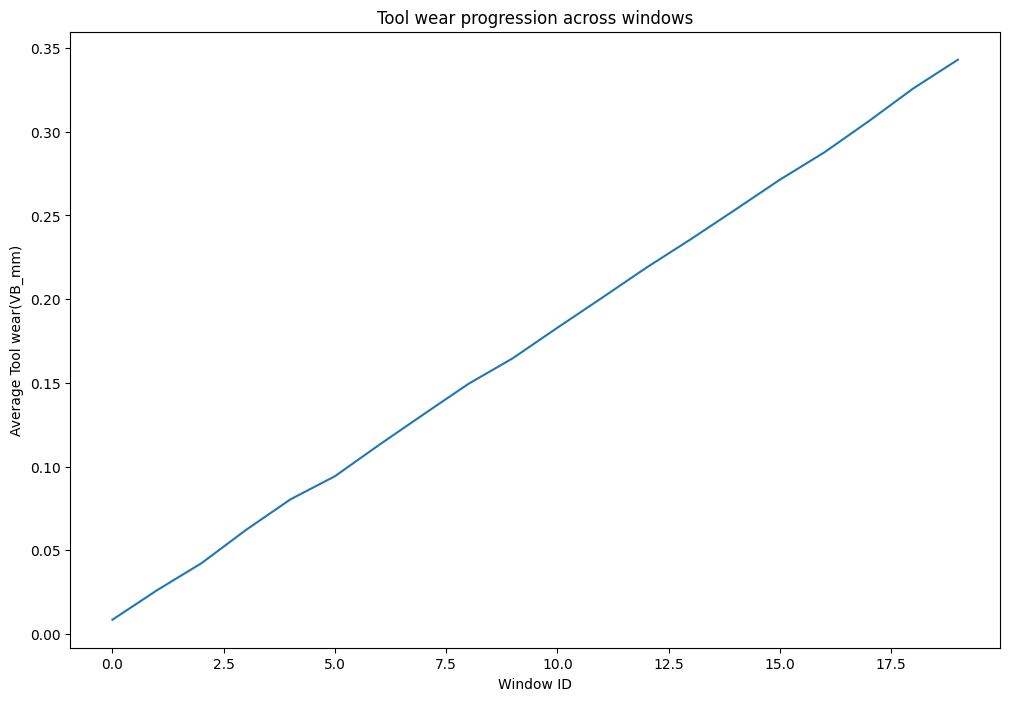

In [17]:
#line plot
plt.figure(figsize=(12,8))
plt.plot(df_updated["Window_ID"],df_updated["VB_mm"])
plt.xlabel("Window ID")
plt.ylabel("Average Tool wear(VB_mm)")
plt.title("Tool wear progression across windows")
plt.show()

In [18]:
print(df_updated["Wear_Class"].value_counts())

Wear_Class
1    8
0    6
2    6
Name: count, dtype: int64


In [19]:
for col in sensor_columns:
    df_updated[f"{col}_mean"]=np.nan
    df_updated[f"{col}_std"]=np.nan
    df_updated[f"{col}_min"]=np.nan
    df_updated[f"{col}_max"]=np.nan
    df_updated[f"{col}_rms"]=np.nan
    df_updated[f"{col}_kurtosis"]=np.nan

for col in sensor_columns:
    col_mean=f"{col}_mean"
    col_std=f"{col}_std"
    col_min=f"{col}_min"
    col_max=f"{col}_max"
    col_kur=f"{col}_kurtosis"
    col_rms=f"{col}_rms"
    for i in range(len(df_updated)):
        df_updated.loc[i,col_mean]=df_updated.loc[i,col].mean()
        df_updated.loc[i,col_std]=df_updated.loc[i,col].std()
        df_updated.loc[i,col_min]=df_updated.loc[i,col].min()
        df_updated.loc[i,col_max]=df_updated.loc[i,col].max()
        df_updated.loc[i,col_kur]=kurtosis(df_updated.loc[i,col])
        df_updated.loc[i,col_rms]=np.sqrt(np.mean(df_updated.loc[i,col]**2))
        
df_updated=df_updated.drop(columns=sensor_columns)
print(df_updated.head())


   Window_ID  Wear_Class     VB_mm  CF_Feature_1_mean  CF_Feature_1_std  \
0          0           0  0.008475          50.471071         29.597164   
1          1           0  0.026057          47.929645         30.088650   
2          2           0  0.042224          54.450367         29.363869   
3          3           0  0.062092          48.045603         29.844148   
4          4           0  0.080370          52.451554         28.915085   

   CF_Feature_1_min  CF_Feature_1_max  CF_Feature_1_rms  \
0          0.919705         99.296480         58.509154   
1          1.099583         98.996023         56.591322   
2          2.997359         97.139509         61.863392   
3          0.756287         99.486632         56.560172   
4          0.766403         99.384839         59.893636   

   CF_Feature_1_kurtosis  CF_Feature_2_mean  ...  AE_Feature_4_min  \
0              -1.184398          52.523233  ...          0.012609   
1              -1.292645          50.483368  ...      

In [20]:
X_base=df_updated.drop(columns=["VB_mm","Wear_Class"])  
y_base=df_updated["VB_mm"]

tscv=TimeSeriesSplit(n_splits=5)

baseline_r2=[]
baseline_rmse=[]

print("Fold | Train Size | Test Size | R2 Score")
print("-"*45)

fold=1
for train_idx,test_idx in tscv.split(X_base):
    X_train,X_test=X_base.iloc[train_idx],X_base.iloc[test_idx]
    y_train,y_test=y_base.iloc[train_idx],y_base.iloc[test_idx]

    model=LinearRegression()
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)

    r2=r2_score(y_test, y_pred)
    rmse=np.sqrt(mean_squared_error(y_test, y_pred))

    baseline_r2.append(r2)
    baseline_rmse.append(rmse)

    print(f"{fold:<4} | {len(train_idx):<10} | {len(test_idx):<9} | {r2:.4f}")
    fold+=1

baseline_r2_mean=np.mean(baseline_r2)
baseline_rmse_mean=np.mean(baseline_rmse)

print("R2 value: ")
print(round(baseline_r2_mean,4))
print("RMSE value: ")
print(round(baseline_rmse_mean,4))


Fold | Train Size | Test Size | R2 Score
---------------------------------------------
1    | 5          | 3         | -27.9476
2    | 8          | 3         | -16.2537
3    | 11         | 3         | -1.3676
4    | 14         | 3         | 0.3150
5    | 17         | 3         | 0.7499
R2 value: 
-8.9008
RMSE value: 
0.0359


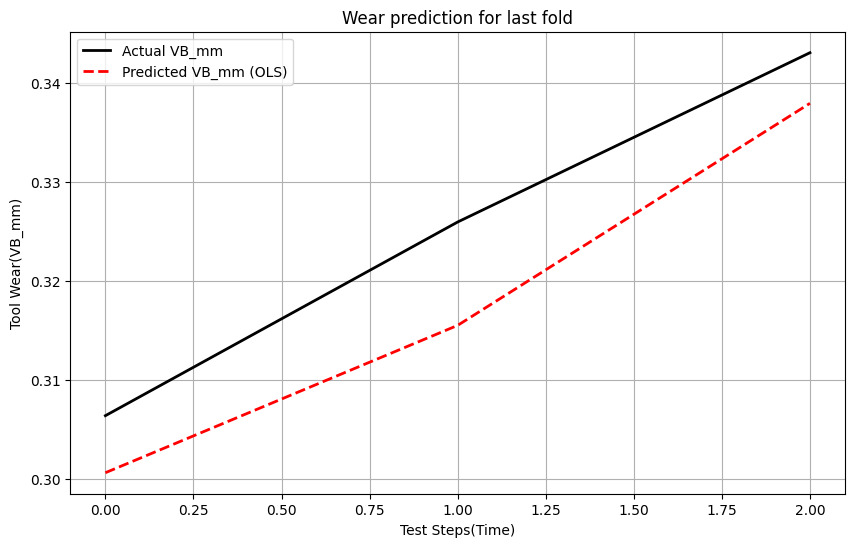

In [21]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values,label='Actual VB_mm',color='black',linewidth=2)
plt.plot(y_pred,label='Predicted VB_mm (OLS)',color='red',linestyle='--',linewidth=2)

plt.title("Wear prediction for last fold")
plt.xlabel("Test Steps(Time)")
plt.ylabel("Tool Wear(VB_mm)")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


#### Sliding window

In [ ]:
#PROPOSED METHOD:SLIDING WINDOWS
window_size=100
overlap=0.5
step_size=int(window_size*(1-overlap))
num_samples=len(df)
start_indices=np.arange(0,num_samples-window_size+1,step_size)

windowed_features=[]
for idx,start in enumerate(start_indices):
    end=start+window_size
    window=df.iloc[start:end,:]
    window_dict={}
    window_dict["Window_ID"]=idx 
    window_dict["Wear_Class"]=window["Wear_Class"].mode()[0]
    window_dict["VB_mm"]=window["VB_mm"].mean()
    for col in sensor_columns:
        data=window[col].values
        
        window_dict[f"{col}_mean"]=np.mean(data)
        window_dict[f"{col}_std"]=np.std(data)
        window_dict[f"{col}_min"]=np.min(data)
        window_dict[f"{col}_max"]=np.max(data)
        window_dict[f"{col}_rms"]=np.sqrt(np.mean(data**2))
        window_dict[f"{col}_kurtosis"]=kurtosis(data)

        
        fft_vals=np.abs(fft(data))
        fft_half=fft_vals[:len(fft_vals)//2]
        window_dict[f"{col}_fft_mean"]=np.mean(fft_half)
        window_dict[f"{col}_fft_std"]=np.std(fft_half)
        window_dict[f"{col}_fft_max"]=np.max(fft_half)

    windowed_features.append(window_dict)
df_features=pd.DataFrame(windowed_features)
print(df_features.head())


   Window_ID  Wear_Class     VB_mm  CF_Feature_1_mean  CF_Feature_1_std  \
0          0           0  0.008475          50.471071         29.597164   
1          1           0  0.016099          51.647992         29.891671   
2          2           0  0.026057          47.929645         30.088650   
3          3           0  0.034205          51.682831         29.715810   
4          4           0  0.042224          54.450367         29.363869   

   CF_Feature_1_min  CF_Feature_1_max  CF_Feature_1_rms  \
0          0.919705         99.296480         58.509154   
1          1.215447         99.296480         59.674342   
2          1.099583         98.996023         56.591322   
3          1.099583         98.484120         59.616645   
4          2.997359         97.139509         61.863392   

   CF_Feature_1_kurtosis  CF_Feature_1_fft_mean  ...  AE_Feature_4_fft_max  \
0              -1.184398             351.515683  ...            281.085298   
1              -1.150019             3

In [ ]:
SAFE_THRESHOLD_VB_MM=0.35 

correlation_scores=df_features.corrwith(df_features["VB_mm"]).abs()
top_sensors=correlation_scores.drop(["VB_mm","Wear_Class"],errors='ignore').nlargest(5).index.tolist()  

selected_features=top_sensors+["Window_ID"] 

X=df_features[selected_features]  
y=df_features["VB_mm"]

tscv=TimeSeriesSplit(n_splits=5)

mae_list,rmse_list,r2_list=[],[],[]

print("Fold"+" "*2+"|"+" "*1+"Train Size"+" "*1+"|"+" "*1+"Test Size"+" "*2+"|"+" "*1+"R2 Score",sep="")
print("-"*50)

fold = 1
for train_idx,test_idx in tscv.split(X):
    X_train,X_test=X.iloc[train_idx],X.iloc[test_idx]
    y_train,y_test=y.iloc[train_idx],y.iloc[test_idx]
    
    model=LinearRegression()
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    mae=mean_absolute_error(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    r2=r2_score(y_test, y_pred)
    
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)    
                      
    print(f"{fold:<5} | {len(train_idx):<10} | {len(test_idx):<10} | {r2:.4f}")
    fold+=1

print("-"*50)
print("Average R²   : ",round(np.mean(r2_list),4))
print("Average RMSE : ",round(np.mean(rmse_list),4))


Fold  | Train Size | Test Size  | R2 Score
--------------------------------------------------
1     | 9          | 6          | 0.9821
2     | 15         | 6          | 0.9869
3     | 21         | 6          | 0.9995
4     | 27         | 6          | 0.9975
5     | 33         | 6          | 0.9886
--------------------------------------------------
Average R²   :  0.9909
Average RMSE :  0.0013


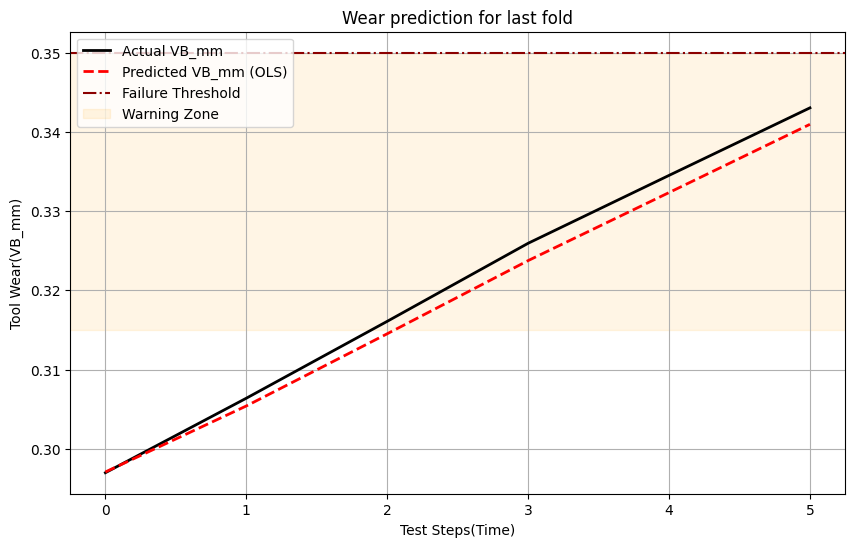

In [24]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values,label='Actual VB_mm',color='black',linewidth=2)
plt.plot(y_pred,label='Predicted VB_mm (OLS)',color='red',linestyle='--',linewidth=2)

plt.axhline(y=SAFE_THRESHOLD_VB_MM,color='darkred',linestyle='-.',linewidth=1.5,label=f'Failure Threshold')
plt.axhspan(SAFE_THRESHOLD_VB_MM * 0.9,SAFE_THRESHOLD_VB_MM,color='orange',alpha=0.1,label='Warning Zone')

plt.title("Wear prediction for last fold")
plt.xlabel("Test Steps(Time)")
plt.ylabel("Tool Wear(VB_mm)")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


#### Comparison

BASELINE vs SLIDING WINDOWS
         Fold  Baseline R²  Baseline RMSE  Sliding R²  Sliding RMSE
0         1.0   -27.947628       0.081523    0.982135      0.002029
1         2.0   -16.253676       0.056972    0.986882      0.001638
2         3.0    -1.367625       0.022045    0.999453      0.000353
3         4.0     0.315017       0.011564    0.997477      0.000748
4         5.0     0.749932       0.007491    0.988555      0.001695
Average   NaN    -8.900800       0.035900    0.990900      0.001300


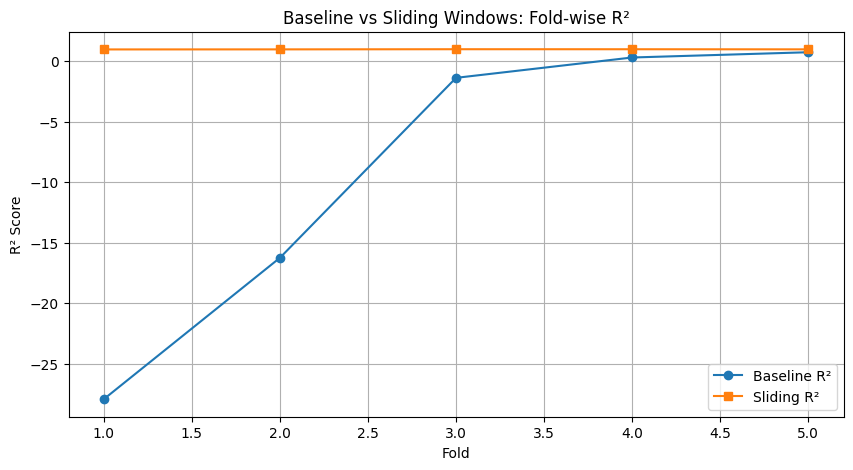

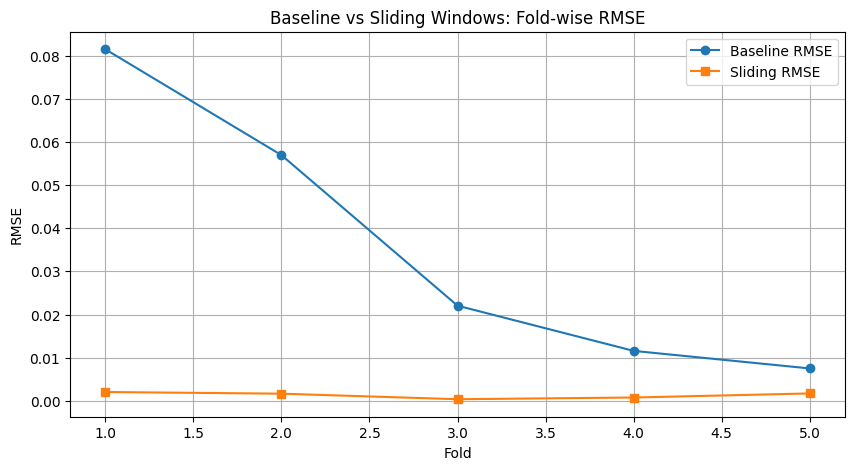

In [25]:
folds=list(range(1,len(baseline_r2)+1))
comparison_df=pd.DataFrame({"Fold":folds,"Baseline R²":baseline_r2,"Baseline RMSE":baseline_rmse,"Sliding R²":r2_list,"Sliding RMSE":rmse_list})

comparison_df.loc["Average"]=[np.nan,round(np.mean(baseline_r2),4),round(np.mean(baseline_rmse),4),round(np.mean(r2_list),4),round(np.mean(rmse_list),4)]

print("BASELINE vs SLIDING WINDOWS")
print(comparison_df)

plt.figure(figsize=(10,5))
plt.plot(folds,baseline_r2,marker='o',label='Baseline R²')
plt.plot(folds,r2_list,marker='s',label='Sliding R²')
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.title("Baseline vs Sliding Windows: Fold-wise R²")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(folds,baseline_rmse,marker='o',label='Baseline RMSE')
plt.plot(folds,rmse_list,marker='s',label='Sliding RMSE')
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Baseline vs Sliding Windows: Fold-wise RMSE")
plt.legend()
plt.grid(True)
plt.show()

#### Real life simulation

In [26]:
print("REAL-TIME MONITORING SIMULATION (LAST FOLD)")


for i,pred_val in enumerate(y_pred):
    status="OK"
    action="Continue Machining"
    
    if pred_val>=SAFE_THRESHOLD_VB_MM:
        status="CRITICAL FAILURE"
        action="STOP MACHINE IMMEDIATELY!!!"
    elif pred_val>=(SAFE_THRESHOLD_VB_MM*0.9):
        status="WARNING"
        action="Schedule Tool Change"
        
    print("Step",i,": Pred=",round(pred_val,4),"mm | Status:",status,"| Action:",action)

REAL-TIME MONITORING SIMULATION (LAST FOLD)
Step 0 : Pred= 0.2971 mm | Status: OK | Action: Continue Machining
Step 1 : Pred= 0.3054 mm | Status: OK | Action: Continue Machining
Step 2 : Pred= 0.3145 mm | Status: OK | Action: Continue Machining
Step 3 : Pred= 0.3238 mm | Status: WARNING | Action: Schedule Tool Change
Step 4 : Pred= 0.3323 mm | Status: WARNING | Action: Schedule Tool Change
Step 5 : Pred= 0.341 mm | Status: WARNING | Action: Schedule Tool Change
